In [25]:
from pyspark import SparkConf, SparkContext

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql import functions as F

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, HashingTF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from time import time

In [26]:
spark = SparkSession \
    .builder \
    .appName("spark") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/hotel.clean") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/hotel.spark") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.1') \
    .getOrCreate()

In [27]:
reviews = spark.read.format("mongo").load()

In [28]:
reviews.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- average_score: double (nullable = true)
 |-- hotel_name: string (nullable = true)
 |-- lat: decimal(20,18) (nullable = true)
 |-- lng: decimal(19,18) (nullable = true)
 |-- review: string (nullable = true)
 |-- review_date: timestamp (nullable = true)
 |-- sentiment: integer (nullable = true)
 |-- tags: string (nullable = true)



In [29]:
# count total documents
reviews.count()

32360

In [30]:
# split dataset into train and test
train, test = reviews.randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 22750
Test Dataset Count: 9610


In [31]:
# setup pipeline
tokenizer = Tokenizer(inputCol="review", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001, labelCol="sentiment")
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

In [32]:
# setup grid cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator().setLabelCol("sentiment"),
                          numFolds=2)  # use 3+ folds in practice

In [33]:
# record train time
t0 = time()

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

tt = time() - t0
print("It took {} seconds to train.".format(tt))

It took 18.9449679851532 seconds to train.


In [34]:
# cvModel uses the best model found (lrModel).
lrModel = cvModel.bestModel.stages[2]

In [35]:
# Make predictions on test documents.
prediction = cvModel.transform(test)
selection = prediction.select("sentiment", "review", "probability", "prediction")

In [36]:
# convert dataframe to RDD for multiclass metrics (such as accuracy).
predictionsAndLabels = selection \
    .select("prediction", "sentiment") \
    .rdd \
    .map(lambda x: [float(x.prediction), float(x.sentiment)])

# Instantiate metrics object
metrics = MulticlassMetrics(predictionsAndLabels)

In [37]:
metrics.confusionMatrix().toArray()

array([[3977.,  426.],
       [ 439., 4768.]])

In [38]:
# overall statistics
accuracy = metrics.accuracy
precision = metrics.weightedPrecision
recall = metrics.weightedRecall
f1Score = metrics.weightedFMeasure()
print("Summary Stats")
print("Accuracy = %s" % accuracy)
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

Summary Stats
Accuracy = 0.9099895941727367
Precision = 0.910013123386972
Recall = 0.9099895941727367
F1 Score = 0.9099996847988967


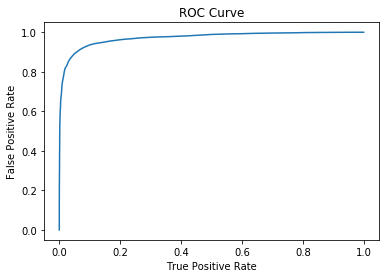

Training set areaUnderROC: 0.9718380401867147


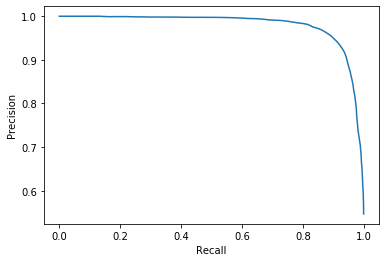

In [39]:
# evaluate
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [41]:
# write predicted reviews to mongo
prediction \
    .select("average_score", "hotel_name", "review_date", "tags", "lat", "lng", "review", F.col("prediction").cast("int").alias("sentiment")) \
    .write.format("mongo").mode("append").save()